# The Preface

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.neighbors import kneighbors_graph

import networkx as nx

from scipy.sparse.linalg import eigs

In [2]:
votes = pd.read_csv("../generated/votes.csv.gz")

**Missing values**<br>
Impute missing values with the mean along the rows. Reasoning: If a parlamentarian didn't participate in the vote, we want him to be as neutral as possible, such that he isn't defined by votes he didn't participate in.

In [3]:
yesno = votes.iloc[:,1:].copy()
yesno[yesno>1] = np.NaN
yesno[yesno<0] = np.NaN

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
yesno_imp = imp.fit_transform(yesno.T).T

# 1. Politician Representations
In the following section, we create different representations for the politicians. In particular, we reduce their voting behavior down to its principal components, explore the manifold of politicians using TSNE and create a nearest-neighbor graph of politicians. We will then reuse the different representations of politicians in order to validate the results of our analysis.

## 1.1 Global PCA
We start off by reducing the politician votes to its principal components using principal component analysis (PCA) of the entire dataset. 

In [5]:
def do_pca(data, explained_var=.75, return_fits=True):
    """
    Rescales variables to have mean zero, then performs PCA.
    
    Parameters
    ----------
    data:
        Data to transform. Rows are observations, columns are features
    explained_var:
        Retains enough principal components to explain "explained_var" percent
        of the total variance
    return_fits:
        If true, returns the rescale fit and the pca fit together with the principal components.
        Otherwise returns only principal components.
    """
    
    # Fit scaler and PCA
    scalefit = StandardScaler(with_std=False).fit(data)
    scaled = scalefit.transform(data)
    pcafit = PCA().fit(scaled)
    
    # Get nb pcs to retain
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    nb_retain = np.where(expl_var>.75)[0][0]
    
    # Project onto PCs
    pc = pcafit.transform(scaled)[:,:nb_retain]
    
    if return_fits:
        return pc, scalefit, pcafit
    else:
        return pc

pc, scalefit, pcafit = do_pca(yesno_imp.T)

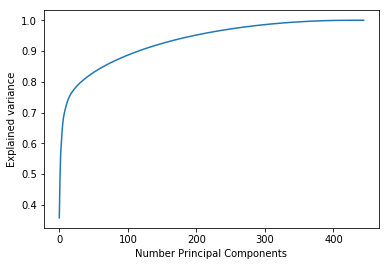

In [6]:
def explained_variance_plot(pcafit):
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    plt.plot(expl_var)
    plt.ylabel("Explained variance")
    plt.xlabel("Number Principal Components")

explained_variance_plot(pcafit)
plt.show()

Very few principal components seem to explain 75% of the data variance already. We thus retain only those principal components for the future analysis.

#### Validation of PCA

*Vote Importance Score*<br>
From the PCA, we can construct an importance score for every individual vote: We do so by determining how much each vote contributes to the most important principal components. A high score means that a vote is very important for determining the politician's general location in the reduced space. We can thus validate the quality of our PCA by looking at the most- and least important votes and determine whether they make sense from a politological point of view.

In [7]:
def vote_importance_score(pc, pcafit):
    """
    Determines vote importance as the summed contribution of the vote to the retained 
    principal components.
    """
    nb_retain = pc.shape[1]
    return np.abs(pcafit.components_[:nb_retain,:]).sum(axis=0)

vote_importance = vote_importance_score(pc, pcafit)

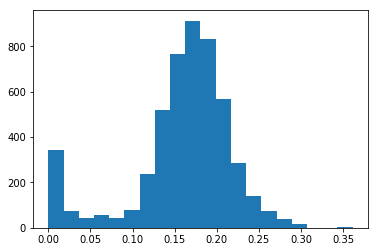

In [8]:
plt.hist(vote_importance, bins=20)
plt.show()

> TODO: Look at the outliers in both directions, see whether they make sense. If yes: Good pca, if not: Bad PCA

*Interpretation of the principal direction*<br>
Another way to validate the PCA is to see whether we can find an interpretation of the principal directions. To this effect, we correlate the principal component scores of the politicians with other attributes known about them, such as their age, gender, number of votes they participated in, etc.

> Moreover it would be interesting to correlate the principal components with other interesting variables about the politicians, such as gender, age, legislature or language, to see whether our principal components have a real-life interpretation.

## 1.2 Non-linear Embedding in 2D with t-SNE

Using the principal component analysis, we embedded the data into a lower-dimensional space using a linear transformation. In order to visualize the data, we need to further reduce it to two dimensions. For this we rely on the non-linear two-dimensional embedding obtained with the t-distributed stochastic neighborhood embedding (t-SNE) algorithm. This algorithm reduces similar politicians to nearby points, whereas dissimilar politicians are far from each other. By doing so it can reveal clusters when they are present in the data. 

In [9]:
def do_tsne(pc):
    return TSNE(random_state=42).fit_transform(pc)

tsne = do_tsne(pc)

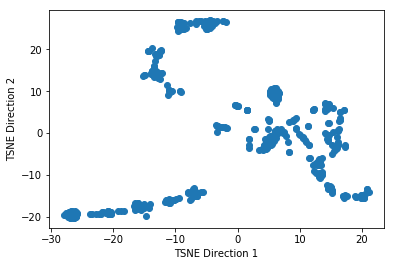

In [10]:
def plot_tsne(tsne):
    plt.scatter(tsne[:,0], tsne[:,1])
    plt.xlabel("TSNE Direction 1")
    plt.ylabel("TSNE Direction 2")

plot_tsne(tsne)
plt.show()

The TSNE plot indicates that certain politicians group together, which manifests in several clusters forming. However, note that the results of the TSNE should be taken with a grain of salt, since its complexity sometimes leads to unexpected results.

## 1.3 Graph Representation
A third way to represent the politicians will be in the form of an undirected graph. The graph is imputed such that every politician is connected to his k nearest neighbors in space. For technical reasons, we want the resulting graph to be connected. Moreover, we will assign as the weight between the two politicians $p_1$ and $p_2$ to be:
$\quad w_{ij} = \exp \{ \frac{1}{2\sigma^2} \|p_1 - p_2\|_2^2 \}$

In [11]:
def get_knn_graph(pc, k=10, sigma=1):
    """
    Obtains knn_graph, returns networkX weighted graph object, where the weights are the 
    graph distance.
    
    Parameters
    ----------
    pc:
        Principal components for graph imputation
    k:
        Number of nearest neighbors to consider
    sigma:
        The variance of the distance kernel
    """
    knn_graph = kneighbors_graph(pc, k, mode="distance")
    
    # Calculate kernel on non-zero elements of sparse matrix
    np.exp( -knn_graph.data / 2*sigma**2, out=knn_graph.data )

    # Create networkx object
    nx_graph = nx.from_scipy_sparse_matrix(knn_graph, edge_attribute='weight')
    if not nx.is_connected(nx_graph):
        warnings.warn("Resulting graph is not connected, spectral embedding may give unexpected results")
    return nx_graph

knn_graph = get_knn_graph(pc, k=10, sigma=.1)

> TODO: Choice of kernel? Does it even make sense to look at kernel or should we just care about connectivity? - more likely the latter, who gives a fuck, and also otherwise it's too similar to the other stuff we do

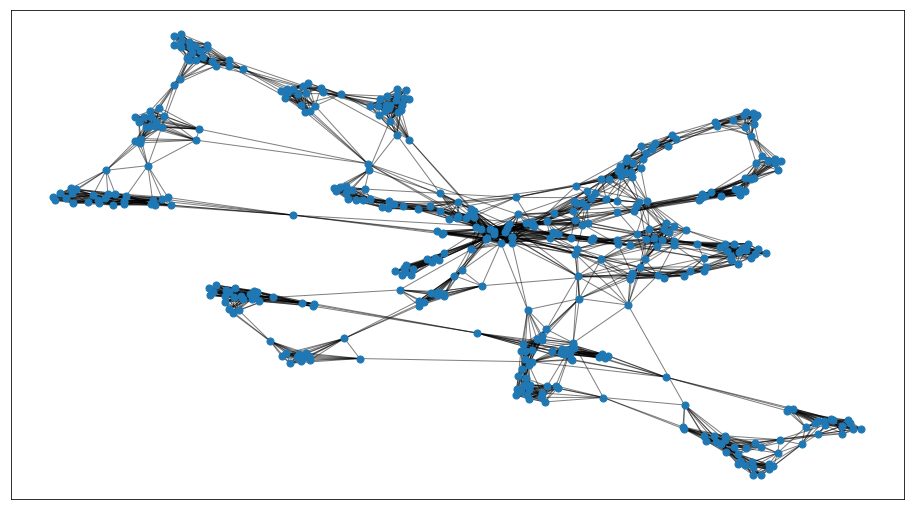

In [24]:
def draw_graph(G, pos=None):
    if pos is None:
        pos=nx.spring_layout(G)
    labels = np.array(list(nx.get_edge_attributes(G,'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=.5)
plt.figure(figsize=(16,9))
draw_graph(knn_graph)

**Spectral Embedding**<br>
The spectral embedding embeds the graph into a n-dimensional space. This can be used for visualizing the graph itself or for spectral clustering, as used below. 
<br><br>
Reference:
*U. Von Luxburg*, “A tutorial on spectral clustering,” *Stat. Comput., vol. 17, no. 4, pp. 395–416, 2007.*

In [17]:
def spectral_embedding(nx_graph, n=15):
    """
    Calculates spectral embedding based on normalized Laplacian matrix.
    
    Parameters
    ----------
    nx_graph:
        NetworkX graph to analyze
    n_evals:
        Number of smallest eigenvalues and corresponding eigenvectors to be computed
        
    Returns
    -------
    evals:
        Eigenvalues of spectral embedding
    evecs:
        Eigenvectors of spectral embedding
    """
    norm_L = nx.normalized_laplacian_matrix(nx_graph)
    evals, evecs = eigs(norm_L, k=n, which="SM")
    evals = np.real(evals)
    evecs = np.real(evecs)
    return evals, evecs

sp_evals, sp_evecs = spectral_embedding(knn_graph)

#### Validation
We validate the graph by looking at its properties.


*Node degree distribution*

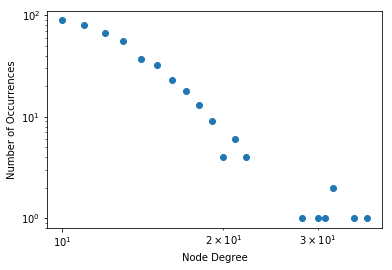

In [18]:
def plot_degree_distribution(graph):
    deg = np.array(graph.degree())[:,1]
    val, count = np.unique(deg, return_counts=True)
    plt.loglog(val, count, 'o')
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Occurrences")
plot_degree_distribution(knn_graph)

Here, we plot the node degree distribution. We see that the upper tail follows a power-law. This behavior is typical for social networks, which suggests that our graph is a good representation for the political landscape.

> We could identify the people with a high degree, which would mean that they have a lot of connections and may make for good candidates for being federal councellors.

# 2. Recovering Clusters

## 2.1 K-Means Clustering

We perform k-means clustering in order to cluster our politicians based on their voting behavior. We do this on the principal components calculated above, in order to avoid the curse of dimensionality.

We run k-means clustering with a range of possible number of clusters. Then, we determine the optimal number of clusters using a so-called knee-plot, which plots the within-cluster variance against the number of clusters. 

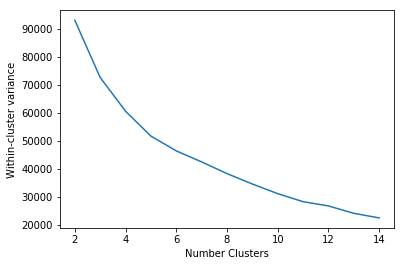

In [19]:
cluster_range = np.arange(2, 15)
kmeans_fit = []
inertia = []
for nc in cluster_range:
    cl = KMeans(n_clusters=nc).fit(pc)
    kmeans_fit.append(cl)
    inertia.append(cl.inertia_)
    
plt.plot(cluster_range, inertia)
plt.ylabel("Within-cluster variance")
plt.xlabel("Number Clusters")
plt.show()

In the knee-plot, the optimal number of clusters can be determined as the "knee" of the graph. In our case, this is somewhat hard to determine, but 6 clusters seem plausible.

In [20]:
ix = np.where(cluster_range==6)[0][0]
kmeans_cl = kmeans_fit[ix].labels_

## 2.2 Graph Based Clustering
In order to validate the clustering, we compare the results with graph-based clustering. For this we impute a graph of politicians as a k-nearest-neighbor graph, where we connect every politician to their k nearest neighbors in the space of the most important principal components. This allows us to perform spectral clustering on the resulting graph.

#### Spectral Clustering
From the spectral decomposition, we can obtain the number of clusters in the graph with the so-called eigengap heuristic: According to it, the number of clusters is given by the value $k$ that maximizes the difference of consecutive eigenvalues.

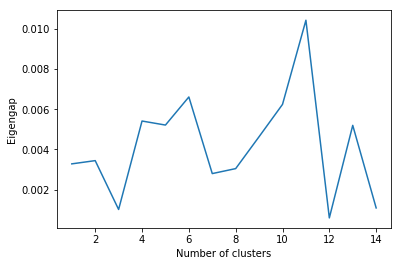

In [21]:
def plot_eigengap(evals):
    n_evals = len(evals)
    
    plt.plot(np.arange(1, n_evals), sp_evals[1:] - sp_evals[:-1])
    plt.xlabel("Number of clusters")
    plt.ylabel("Eigengap")
    plt.show()
    
plot_eigengap(sp_evals)

The plot suggests that $k=4$ or $k=7$ clusters seem to be present within the graph. We determine the cluster assingment as follows: We take the $k$ first dimensions of the spectral embedding and perform k-means clustering in that space.

In [22]:
def spectral_clustering(evecs, k):
    red = evecs[:,:k]
    clusters = KMeans(n_clusters=k).fit_predict(red)
    return clusters

spec_cl_4 = spectral_clustering(sp_evecs, 4)
spec_cl_7 = spectral_clustering(sp_evecs, 7)

## 2.3 Clustering Result Comparison
We now go back to our TSNE plot to visualize the different clusterings we obtained so far.

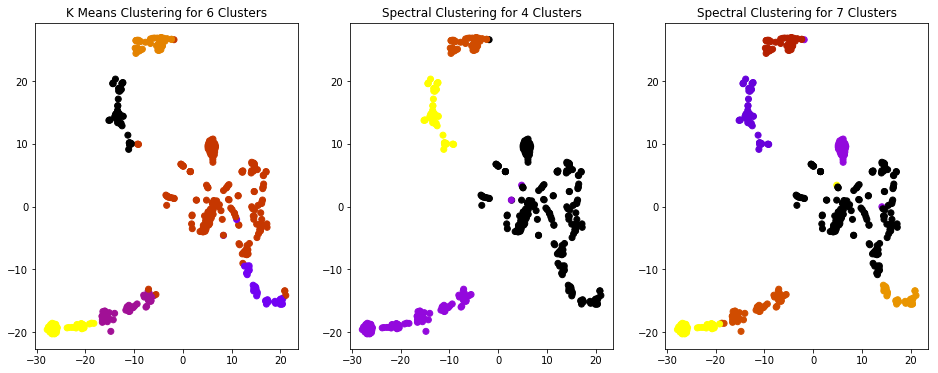

In [23]:
def visualize_clusterings(coordinates, clusters):
    plt.scatter(coordinates[:,0], coordinates[:,1], c=clusters, cmap="gnuplot")
    
plt.figure(figsize=(16,6))

plt.subplot(131)
plt.title("K Means Clustering for 6 Clusters")
visualize_clusterings(tsne, kmeans_cl)

plt.subplot(132)
plt.title("Spectral Clustering for 4 Clusters")
visualize_clusterings(tsne, spec_cl_4)

plt.subplot(133)
plt.title("Spectral Clustering for 7 Clusters")
visualize_clusterings(tsne, spec_cl_7)


We observe that the three clustering procedures seem to cluster similarly. Moreover, the clusters seem to be in accordance to what can visually be identified as clusters on the TSNE plots. This suggests that the clustering is pretty robust, which in turn indicates that politicians seem to form clusters.

# Intermediary Conclusions
What have we learned so far? There are two key conclusions that can be drawn from our analysis so far:
- From the fact that we recover similar clusterings with different clustering methods, we conclude that politicians can be grouped together according to their voting behavior.
- We constructed a graph of all politicians, which has the properties of a social network and from which the clusters can be recovered. This suggests that the graph representation is of good quality, and will provide a useful tool in our future analysis.

> TODO: Better structure the conclusions, the second one is already there earlier
> TODO: Tell guarin to go fuck himself, repeatedly
